In [1]:
import pandas as pd

dataset = pd.read_excel('/content/Historical_closing_prices.xlsx', index_col='ISIN')

In [2]:
dataset = dataset.sort_values(by='maturity date')
dataset.to_csv('dataset.csv')

In [3]:
# Select 10 bonds
dataset = dataset.loc[['CA135087K866', 'CA135087L369', 'CA135087L856', 
                        'CA135087M763', 'CA135087J546', 'CA135087J967', 
                        'CA135087K528', 'CA135087K940', 'CA135087L518', 
                        'CA135087L930']]
dataset.to_csv('selected_dataset.csv')
print(dataset)

              coupon issue date  ... 2022-01-20 00:00:00  2022-01-21 00:00:00
ISIN                             ...                                         
CA135087K866  0.0150 2020-01-27  ...              100.26               100.27
CA135087L369  0.0025 2020-08-17  ...               99.43                99.46
CA135087L856  0.0025 2021-02-05  ...               98.87                98.92
CA135087M763  0.0050 2021-08-09  ...               98.66                98.72
CA135087J546  0.0225 2018-10-05  ...              101.88               101.97
CA135087J967  0.0150 2019-04-05  ...              100.17               100.27
CA135087K528  0.0125 2019-10-11  ...               99.10                99.26
CA135087K940  0.0050 2020-04-03  ...               96.19                96.31
CA135087L518  0.0025 2020-10-09  ...               94.52                94.70
CA135087L930  0.0100 2021-04-16  ...               97.00                97.22

[10 rows x 13 columns]


Updated all the clean prices to dirty prices using the formula:
DP = CP + (accrued interest) where 
$$AI=\frac{n}{\frac{365}{2}}*\frac{coupon\;rate}{2}*100=\frac{n}{365} * (coupon\;rate) * 100$$
$n$ denotes the number of days passed since the last coupon payment.

In [4]:
def dirty_price(n, d):
  """returns the dirty price of the bond <ISIN> on <day>"""
  bond = dataset.index[n]
  day = dataset.columns[d]
  ind = n + 1
  clean_price = dataset.loc[bond, day] # this is the closing price
  coupon = 100 * dataset.loc[bond, 'coupon']
  # assume that 6 months = 183 days
  timestamp = dataset.loc[bond, 'maturity date'] - datetime.timedelta(days=183*ind) # now we are at the last coupon payment date
  timestamp = (day - timestamp).days # the number of days passed since the last coupon payment
  accrued_interest = timestamp / 365 * coupon
  return clean_price + accrued_interest

import datetime

# create a new dataset that contains the dirty price instead of clean price
df_dirty_price = dataset.copy()
for n in range(len(dataset.index)):
  bond = dataset.index[n]
  for d in range(len(dataset.columns)):
    day = dataset.columns[d] 
    if isinstance(day, datetime.datetime):
      df_dirty_price.loc[bond, day] = dirty_price(n, d)

In [5]:
df_dirty_price.to_csv('dirty price.csv')

To calculate the yield rate, we use the following formula:
$DP_n = \sum_{i=1}^n C_n(1+\frac{ytm_n}{2})^{-i}+F(1+\frac{ytm_n}{2})^{-n}$

In [6]:
yield_df = df_dirty_price.copy()

In [7]:
from scipy import optimize

def ytm_total(n, d, c):
  """returns ytm_total - DP"""
  bond = df_dirty_price.index[n]
  day = df_dirty_price.columns[d]
  summand = 0
  i = 0
  while i <= n:
    coupon = df_dirty_price.loc[bond, 'coupon']/2*100 * ((1+c/2)**(-(i+1)))
    summand += coupon
    i += 1
  summand += 100 * ((1+c/2)**(-(n+1)))
  return summand - df_dirty_price.iloc[n, d]

for n in range(len(df_dirty_price.index)):
  for d in range(3, len(df_dirty_price.columns)):
    # set the initial assumption to be the coupon rate
    initial = df_dirty_price.iloc[n, 0]
    ytm = lambda c: ytm_total(n, d, c)
    if df_dirty_price.iloc[n, d] < 100:
      yield_df.iloc[n, d] = optimize.ridder(ytm, initial, 1)
    elif df_dirty_price.iloc[n, d] > 100:
      yield_df.iloc[n, d] = optimize.ridder(ytm, 0, initial)
    else:
      yield_df.iloc[n, d] = initial

yield_df.to_csv('yield_rate.csv')

In [8]:
yield_df

,coupon,issue date,maturity date,2022-01-10 00:00:00,2022-01-11 00:00:00,2022-01-12 00:00:00,2022-01-13 00:00:00,2022-01-14 00:00:00,2022-01-17 00:00:00,2022-01-18 00:00:00,2022-01-19 00:00:00,2022-01-20 00:00:00,2022-01-21 00:00:00
ISIN,,,,,,,,,,,,,
CA135087K866,0.0150,2020-01-27,2022-05-01,0.002069,0.002186,0.002104,0.002420,0.002538,0.002889,0.003007,0.002925,0.003042,0.002761
CA135087L369,0.0025,2020-08-17,2022-11-01,0.006533,0.006627,0.006822,0.006815,0.007010,0.007696,0.007992,0.007783,0.007675,0.007365
CA135087L856,0.0025,2021-02-05,2023-05-01,0.008348,0.008411,0.008542,0.008605,0.008803,0.009535,0.009869,0.009729,0.009724,0.009380
CA135087M763,0.0050,2021-08-09,2023-11-01,0.009714,0.009757,0.009903,0.009998,0.010144,0.010888,0.011188,0.011283,0.011225,0.010911
CA135087J546,0.0225,2018-10-05,2024-03-01,0.009771,0.009747,0.009922,0.010056,0.010191,0.010876,0.011171,0.011187,0.011242,0.010857
CA135087J967,0.0150,2019-04-05,2024-09-01,0.011239,0.010988,0.011008,0.011129,0.011318,0.012054,0.012312,0.012501,0.012419,0.012066
CA135087K528,0.0125,2019-10-11,2025-03-01,0.012200,0.012103,0.012268,0.012317,0.012600,0.013274,0.013646,0.013665,0.013684,0.013204
CA135087K940,0.0050,2020-04-03,2025-09-01,0.013126,0.012965,0.012831,0.012827,0.013059,0.013705,0.014148,0.014434,0.014325,0.014006
CA135087L518,0.0025,2020-10-09,2026-03-01,0.013523,0.013380,0.013496,0.013448,0.013682,0.014364,0.014885,0.014955,0.014905,0.014476


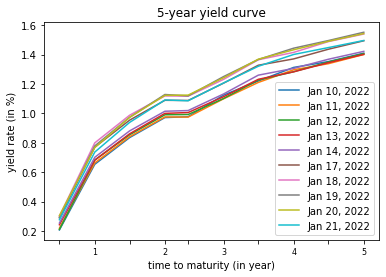

In [9]:
# plot
import matplotlib.pyplot as plt

for day in dataset.columns:
  if isinstance(day, datetime.datetime):
    plt.plot(dataset['maturity date'], yield_df[day]*100, label=day.strftime("%b %d, %Y"))
plt.legend()

import datetime

format = ['', '1', '', '2', '', '3', '', '4', '', '5']
plt.xticks(dataset['maturity date'], format, fontsize=8)
plt.title('5-year yield curve')
plt.xlabel('time to maturity (in year)')
plt.ylabel('yield rate (in %)')
plt.savefig('APM466_yield_curve.png')
plt.show()

To calculate the spot rate, use the following formula:
$$DP_n=\sum_{i=1}^n C_n e^{-r_i \cdot t_i} + F e^{-r_n \cdot t_n}$$

In [10]:
spot_df = df_dirty_price.copy()

In [11]:
import math

# with dirty_price, we will calculate the spot rate
def spot_rate(ISIN, price, day):
  """returns the spot rate of the bond <ISIN> on <day>"""
  # face value + last coupon payment
  notional = 100 * (1+dataset.loc[ISIN, 'coupon']/2)
  # time to maturity
  timestamp = (dataset.loc[ISIN, 'maturity date'] - day).days / 365
  return - math.log(price/notional) / timestamp

def update_pv(n, d):
  bond = dataset.index[n]
  day = dataset.columns[d]
  i = 0
  P = df_dirty_price.loc[bond, day]
  while i < n:
    coupon = df_dirty_price.iloc[n,0] / 2 * 100
    timestamp = (spot_df.iloc[i,2] - day).days/365
    coupon *= math.exp(-spot_df.iloc[i, d]*timestamp)
    P -= coupon
    i += 1
  return P

In [12]:
for n in range(len(dataset.index)):
  bond = dataset.index[n]
  for d in range(len(dataset.columns)):
    day = dataset.columns[d]
    if isinstance(day, datetime.datetime):
      P = update_pv(n, d)
      rate = spot_rate(bond, P, day)
      spot_df.iloc[n, d] = rate

In [13]:
spot_df.to_csv('spot rate.csv')

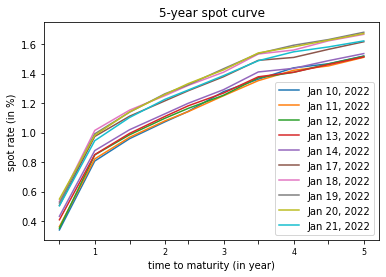

In [14]:
# plot
import matplotlib.pyplot as plt

for day in dataset.columns:
  if isinstance(day, datetime.datetime):
    plt.plot(dataset['maturity date'], spot_df[day]*100, label=day.strftime("%b %d, %Y"))
plt.legend()

import datetime

format = ['', '1', '', '2', '', '3', '', '4', '', '5']
plt.xticks(dataset['maturity date'], format, fontsize=8)
plt.title('5-year spot curve')
plt.xlabel('time to maturity (in year)')
plt.ylabel('spot rate (in %)')
plt.savefig('APM466_spot_curve.png')
plt.show()

4c. Using spot rates, we will compute the 1-year forward rate with the following formula: $e^{r_n*t_n}=e^{r_1*t_1}*e^{f_{[1,n]} \cdot (t_n-t_1)}$

In [15]:
forward_df = spot_df.copy()
forward_df.iloc[0:3, 3:] = 0

In [16]:
for n in range(3, len(forward_df.index)):
  bond = forward_df.index[n]
  t1n = (forward_df.loc[bond, 'maturity date']-forward_df.iloc[1,2]).days/365
  for d in range(len(forward_df.columns)):
    day = forward_df.columns[d]
    if isinstance(day, datetime.datetime):
      t01 = (forward_df.iloc[1, 2] - day).days/365
      t0n = (forward_df.loc[bond, 'maturity date']-day).days/365
      r1 = spot_df.iloc[1, d]
      rn = spot_df.iloc[n, d]
      forward_df.iloc[n, d] = (rn*t0n - r1*t01)/t1n

forward_df.to_csv('1-year forward rate.csv')

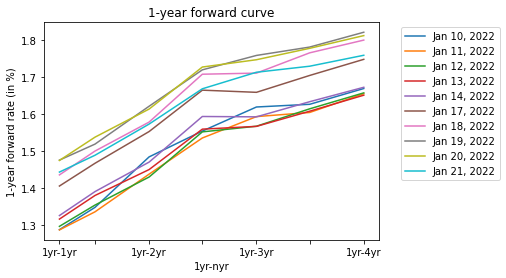

In [17]:
# plot
import matplotlib.pyplot as plt

for day in dataset.columns:
  if isinstance(day, datetime.datetime):
    plt.plot(forward_df['maturity date'].iloc[3:,], 
             forward_df[day].iloc[3:,]*100, label=day.strftime("%b %d, %Y"))
plt.legend()

import datetime

format = ['1yr-1yr', '', '1yr-2yr', '', '1yr-3yr', '', '1yr-4yr']
plt.xticks(forward_df['maturity date'].iloc[3:,], format)
plt.title('1-year forward curve')
plt.xlabel('1yr-nyr')
plt.ylabel('1-year forward rate (in %)')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig('APM466_1yr_forward_curve.png', bbox_inches='tight')
plt.show()

5 Covariance of daily log-returns of yield rates

In [18]:
import numpy as np

yield_matrix = []

for n in range(1, len(forward_df.index), 2):
  b = []
  for d in range(3, len(forward_df.columns)-1):
    x_ij = math.log(yield_df.iloc[n, d+1] / yield_df.iloc[n, d])
    b.append(x_ij)
  yield_matrix.append(b)

yield_m = np.array(yield_matrix)
yield_cov = np.cov(yield_m)

In [19]:
yield_cov

array([[0.00162126, 0.0009987 , 0.00085001, 0.00067166, 0.00081897],
       [0.0009987 , 0.00071091, 0.00067109, 0.000542  , 0.00059184],
       [0.00085001, 0.00067109, 0.00073446, 0.00059545, 0.00058656],
       [0.00067166, 0.000542  , 0.00059545, 0.00055313, 0.00051467],
       [0.00081897, 0.00059184, 0.00058656, 0.00051467, 0.00053757]])

5 Covariance of daily log-returns of forward rates

In [20]:
import numpy as np

forward_matrix = []

for n in range(3, len(forward_df.index), 2):
  b = []
  for d in range(3, len(forward_df.columns)-1):
    x_ij = math.log(forward_df.iloc[n, d+1] / forward_df.iloc[n, d])
    b.append(x_ij)
  forward_matrix.append(b)

forward_m = np.array(forward_matrix)
forward_cov = np.cov(forward_m)

In [21]:
forward_cov

array([[0.000496  , 0.00054673, 0.00043765, 0.00044421],
       [0.00054673, 0.0007122 , 0.00055748, 0.00050441],
       [0.00043765, 0.00055748, 0.00053019, 0.00045471],
       [0.00044421, 0.00050441, 0.00045471, 0.00047574]])

6 - Calculate the eigenvalues and eigenvectors of both covariance matrices

In [22]:
from numpy import linalg as LA

eigenvalue_yield, eigenvector_yield = LA.eig(yield_cov)
eigenvalue_forward, eigenvector_forward = LA.eig(forward_cov)

In [23]:
print(eigenvalue_yield, eigenvector_yield)

[3.73385153e-03 3.50892557e-04 5.01056458e-05 1.53898738e-05
 7.08898961e-06] [[-0.62296554  0.69591947  0.10282834 -0.33031245 -0.08905077]
 [-0.4315786   0.00134837 -0.32149117  0.79339478 -0.28444023]
 [-0.41356717 -0.45329686 -0.64382525 -0.42251851  0.17450303]
 [-0.34247692 -0.52784256  0.5485164  -0.15279743 -0.52903165]
 [-0.37057469 -0.17775953  0.41314472  0.24402758  0.77513736]]


In [24]:
print(eigenvalue_forward, eigenvector_forward)

[2.04158415e-03 1.93220481e-05 7.45206519e-05 7.86996452e-05] [[ 0.47265139  0.57578515 -0.60322813 -0.284935  ]
 [ 0.57295801 -0.4182961   0.34101766 -0.61680989]
 [ 0.48658051  0.44617246  0.5840337   0.47230729]
 [ 0.45995563 -0.54261402 -0.42276166  0.56150104]]
